# bagged_gbc

In [27]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.ensemble         import GradientBoostingClassifier

from sklearn.ensemble         import BaggingClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [28]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = False

submission_filename = "../submissions/submission_bagged_gbc.csv"

# Load the training data

In [29]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Train the model

In [30]:
%%time

random.seed(SEED)


# ------------------------------ base estimator ---------------------------------
base = GradientBoostingClassifier(loss                     = 'exponential',
                                  learning_rate            = 0.15, 
                                  n_estimators             = 175, 
                                  max_depth                = 1, 
                                  subsample                = 0.75, 
                                 
                                  min_samples_split        = 2, 
                                  min_samples_leaf         = 1, 
                                  #min_weight_fraction_leaf = 0.0, 
                                  init                     = None, 
                                  random_state             = SEED, 
                                  max_features             = None, 
                                  verbose                  = 0, 
                                  max_leaf_nodes           = None, 
                                  warm_start               = False) 
                                  #presort                  = 'auto')

# ---------------------------- BaggingClassifier ---------------------------------

clf = BaggingClassifier(base_estimator     = base, 
                        n_estimators       = 10,
                        
                        max_samples        = 1.0, 
                        max_features       = 1.0, 
                        bootstrap          = True, 
                        bootstrap_features = False, 
                        
                        oob_score          = False, 
                        warm_start         = False, 
                        n_jobs             = 1, 
                        random_state       = SEED, 
                        verbose            = 0)



# StatifiedCV = StratifiedKFold(y            = y_train, 
#                               n_folds      = 10, 
#                               shuffle      = True, 
#                               random_state = SEED)

# param_grid = dict(max_samples        = [0.25, 0.50, 0.75, 1.0],
#                   max_features       = [0.25, 0.50, 0.75, 1.0],
#                   bootstrap          = [True, False],
#                   bootstrap_features = [True, False])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV,
#                         verbose    = 0
#                        )

# grid_clf.fit(X = X_train, y = y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(round(grid_clf.best_score_, 4)))
# print

# clf = grid_clf.best_estimator_




clf_params = {'max_features': 0.75, 'max_samples': 0.5, 'bootstrap': False, 'bootstrap_features': False}
clf_params['n_jobs'] = -1
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 72 ms, sys: 28 ms, total: 100 ms
Wall time: 366 ms


In [31]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

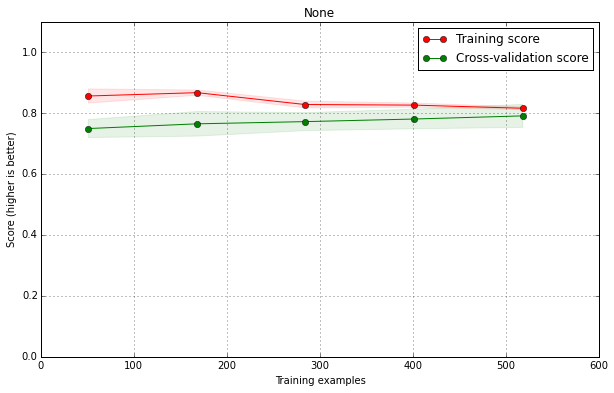

CPU times: user 11.9 s, sys: 4.07 s, total: 16 s
Wall time: 34.9 s


In [32]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = 1)

plt.show()

# Training set predictions

In [33]:
predicted_values = clf.predict(X_train)
y_true, y_pred   = y_train, predicted_values

try:
    predicted_probs  = clf.predict_proba(X_train)
    probs_avail = True
except AttributeError,e:
    probs_avail = False
    print(e)

[[417  21]
 [ 88  50]]


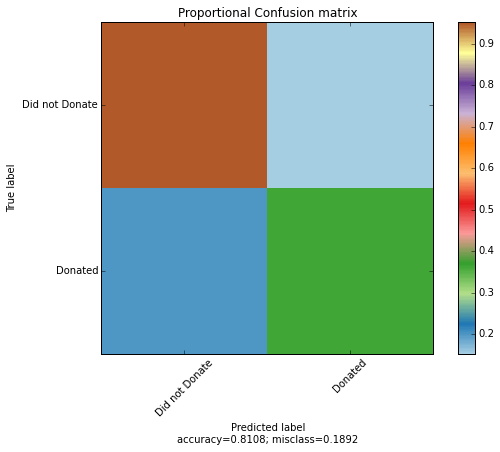

Accuracy 0.8108, mis-class rate 0.1892


In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

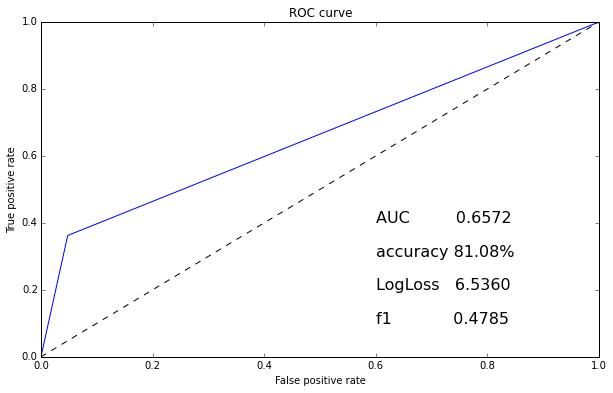

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1            {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Load the test data

In [36]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [37]:
y_pred        = clf.predict(X_test)
if probs_avail:
    y_pred_probs  = clf.predict_proba(X_test)
    donate_probs  = [prob[1] for prob in y_pred_probs]
else:
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]

In [38]:
print(y_pred[:10])
if probs_avail: print(y_pred_probs[:10])
print(donate_probs[:10])

[0 0 0 0 1 1 0 0 0 0]
[[ 0.60294448  0.39705552]
 [ 0.80189223  0.19810777]
 [ 0.82778596  0.17221404]
 [ 0.69961581  0.30038419]
 [ 0.47036664  0.52963336]
 [ 0.09561834  0.90438166]
 [ 0.70877632  0.29122368]
 [ 0.9591084   0.0408916 ]
 [ 0.97481353  0.02518647]
 [ 0.98257413  0.01742587]]
[0.39705552396159638, 0.19810777189126705, 0.17221404481928801, 0.30038419006148509, 0.52963336299652553, 0.90438165876083931, 0.29122367563814677, 0.040891601910195315, 0.025186473623049793, 0.01742586558028008]


# Create the submission file

In [39]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()